In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ztest
from scipy.stats import sem

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

## Read in the Data

This data was taken from the Kaggle competition [Heart Failure Prediction](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data). The purpose of this analysis is to determine what factors contribute to heart failure and develop a model that can help prediction whether or not a heart failure will occur based on the data provided.

In [4]:
data = pd.read_csv("../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")

## Explore the Data

The description on each column are as follows:
- age: Age of the patient
- anaemia: Decrease of red blood cells or hemoglobin (boolean)
- creatinine_phosphokinase: Level of CPK enzyme
- diabetes: If the patient has diabetes (boolean)
- ejection_fraction: Percentage of blood leaving the head at each contraction (percentage)
- high_blood_pressure: If the patient has hypertension (boolean)
- platelets: Platelets in the blood
- serum_creatinine: Level of serum creatinine
- serum_sodium: Level of serum sodium
- sex: 0 = Female, 1 = Male
- smoking: If the patient smokes (boolean)
- time: Follow-up period in days
- DEATH_EVENT: If the patient deceased during the follow-up period (boolean)

In [5]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [7]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Based on a quick glance, there does not appear to be any null values or any outstanding faults with the data.

# Data Analysis

As stated above, the purpose is to determine if there are any factors that could contribute, or signify, a higher chance of a heart failure. Therefore I want to see how the averages for each feature compare between death events and non-death events then see if those averages are statistically different from each other.

In [46]:
# Calculate the average of features grouped by 'DEATH_EVENT'
avg_by_death = data.groupby('DEATH_EVENT').mean().transpose()
print('Total number of deaths: %i' %data['DEATH_EVENT'].sum())
print('Percent of DEATH_EVENTS: %f' %(data['DEATH_EVENT'].sum()/len(data)))
avg_by_death

Total number of deaths: 96
Percent of DEATH_EVENTS: 0.321070


DEATH_EVENT,0,1
age,58.761906,65.215281
anaemia,0.408867,0.479167
creatinine_phosphokinase,540.054187,670.197917
diabetes,0.418719,0.416667
ejection_fraction,40.266010,33.468750
high_blood_pressure,0.325123,0.406250
platelets,266657.489901,256381.044792
serum_creatinine,1.184877,1.835833
serum_sodium,137.216749,135.375000
sex,0.650246,0.645833


In [67]:
# Calculate the standard error in the means by DEATH_EVENT
sem_by_death = data.groupby('DEATH_EVENT').sem().transpose()

Now that the averages have been calculated, I want to test their statistical significance to determine how different the averages are across `DEATH_EVENT`. The following determines the averages of each feature, based on death events, and calculates if the differences are statically significant.

In [75]:
for col in data.columns[:-1]:
    print(col)

age
anaemia
creatinine_phosphokinase
diabetes
ejection_fraction
high_blood_pressure
platelets
serum_creatinine
serum_sodium
sex
smoking
time


In [11]:
# Calculate the statistical significance between averages amongst features with 0.05 significance
for col in data.columns[:-1]:
    # Z test for statistical difference between average DEATH_EVENT by column
    non_death_events = data[data['DEATH_EVENT'] == 0][col]
    death_events = data[data['DEATH_EVENT'] == 1][col]
    
    ttest, pval = ztest(x1 = non_death_events, x2 = death_events)
    
    if pval <= 0.05:
        print('The null hypothesis can be rejected for %s. The averages are statistically different' %col)
    else:
        print('The null hypothesis cannot be rejected %s. The averages are not statistically different' %col)

The null hypothesis can be rejected for age. The averages are statistically different
The null hypothesis cannot be rejected anaemia. The averages are not statistically different
The null hypothesis cannot be rejected creatinine_phosphokinase. The averages are not statistically different
The null hypothesis cannot be rejected diabetes. The averages are not statistically different
The null hypothesis can be rejected for ejection_fraction. The averages are statistically different
The null hypothesis cannot be rejected high_blood_pressure. The averages are not statistically different
The null hypothesis cannot be rejected platelets. The averages are not statistically different
The null hypothesis can be rejected for serum_creatinine. The averages are statistically different
The null hypothesis can be rejected for serum_sodium. The averages are statistically different
The null hypothesis cannot be rejected sex. The averages are not statistically different
The null hypothesis cannot be reje

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:744: RuntimeWarning:

divide by zero encountered in double_scalars



The only features that seem to have statistically different means across `DEATH_EVENT` are `age`, `time`, `serum_creatinine`, `serum_sodium`, and `ejection_fraction`. Interestingly, `high_blood_pressure`, `diabetes`, `smoking`, or `sex` don't appear to be significant factors that could help predict heart failures based on the data. The above analysis is visualized below.

In [88]:
# Plot box plots for non-boolean columns
for col in data.columns[:-1]:
    figure = go.Figure()
    figure.add_trace(go.Bar(name = 'DEATH_EVENT = 1',
                            x = ['DEATH_EVENT = 1'],
                            y = [avg_by_death[1][col]],
                            error_y = dict(type='data', array = [sem_by_death[1][col]])))
    figure.add_trace(go.Bar(name = 'DEATH_EVENT = 0',
                            x = ['DEATH_EVENT = 0'],
                            y = [avg_by_death[0][col]],
                            error_y = dict(type='data', array = [sem_by_death[0][col]])))
    figure.update_layout(title_text = 'Mean ' + col)
    figure.show()

96 out of 299 observations are death events.

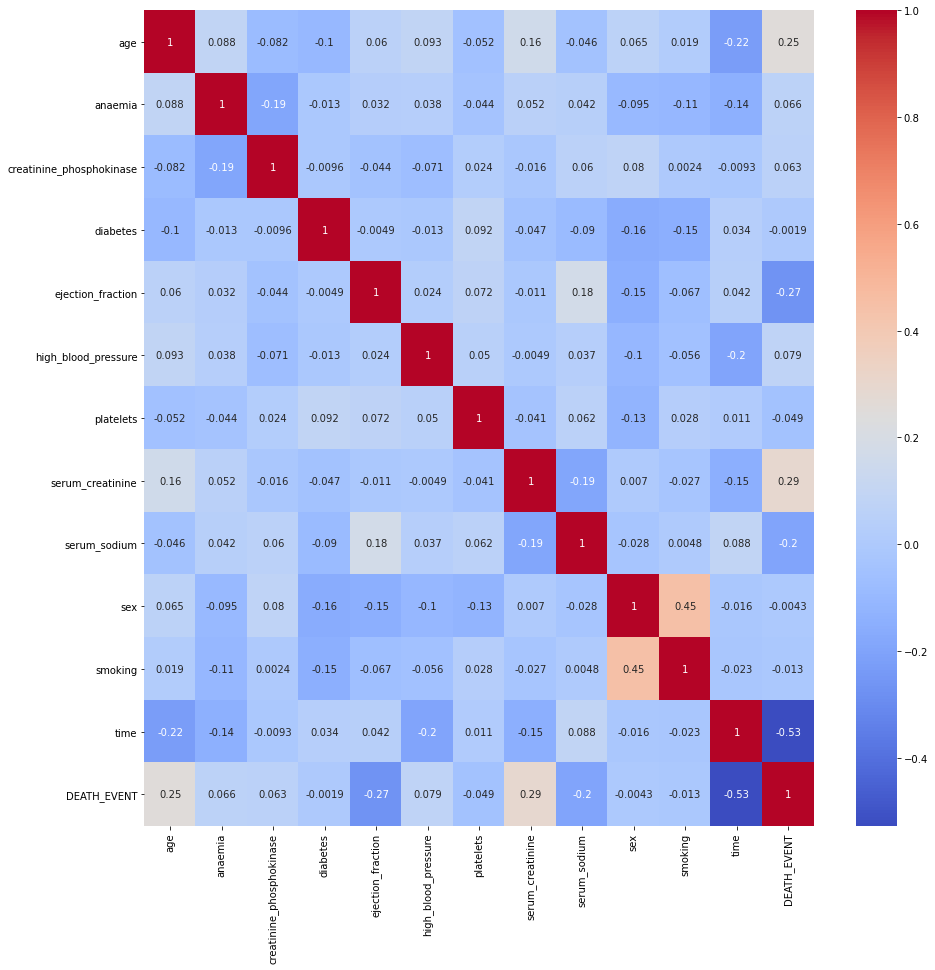

In [12]:
# Plot the correlation graph between variables
_ = plt.figure(figsize=(15,15))
_ = sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
_ = plt.show()

Again, `age`, `ejection_fraction`, `serum_creatinine`, `serum_sodium`, and `time` appear to have the highest correlation to `DEATH_EVENT` which will be focused on in the following anayses. Also worth noting:
- There's a slight correlation between `age` and `serum_creatinine`
- There's a slight correlation between `sex` and `ejection_fraction`
- There's a slight correlation between `age` and `time`


### Gender Analysis

Like stated above, it's an interesting note that `gender`, `high_blood_pressure`, `diabetes`, and `smoking` don't play a role in determining a `DEATH_EVENT` according to this data. The following investigates these variables.

In [18]:
# Create a function to plot pie charts for boolean variables colored by DEATH_EVENT
def cat_pie_by_de(category, category_true_label, category_false_label):
    '''Plots pie charts for a given category by DEATH_EVENT'''
    
    # Creates value counts for a true/false (positive/negative) boolean value by DEATH_EVENT
    true_de = data.loc[(data[category] == 1) & (data['DEATH_EVENT'] == 1), 'DEATH_EVENT'].count()
    true_nde = data.loc[(data[category] == 1) & (data['DEATH_EVENT'] == 0), 'DEATH_EVENT'].count()
    false_de = data.loc[(data[category] == 0) & (data['DEATH_EVENT'] == 1), 'DEATH_EVENT'].count()
    false_nde = data.loc[(data[category] == 0) & (data['DEATH_EVENT'] == 0), 'DEATH_EVENT'].count()
    
    # Creates lists for true/false (positive/negative) boolean values with death and non-death counts
    true_pie_values = [true_de,  true_nde]
    false_pie_values = [false_de, false_nde]
    
    # Creates labels for the pie charts
    true_labels = ['%s Death Events' %category_true_label, '%s non-Death Events' %category_true_label]
    false_labels = ['%s Death Events' %category_false_label, '%s non-Death Events' %category_false_label]
    
    # Makes a subplot for two pie charts
    figure = make_subplots(rows = 1, cols = 2,
                      column_widths=[0.5,0.5],
                      specs = [[{"type":"pie"}, {"type":"pie"}]])
    
    # Creates a pie chart for true (positive) boolean values colored by DEATH_EVENT
    figure.add_trace(
        go.Pie(labels = true_labels, values = true_pie_values, title = category_true_label),
        row = 1, col = 1)
    
    # Creates a pie chart for false (negative) boolean values colored by DEATH_EVENT
    figure.add_trace(
        go.Pie(labels = false_labels, values = false_pie_values, title = category_false_label),
        row = 1, col = 2)

    # Adds a title to the pie charts
    figure.update_layout(title = "Death Event by %s" %category)

    # Plots the charts
    figure.show()

In [19]:
# Plot the pie charts for sex
cat_pie_by_de(category = 'sex',
              category_true_label = 'Male',
              category_false_label = 'Female')

From the pie chart above, the percentages between `DEATH_EVENT` for both genders don't differ too significantly which might explain why it it's not helpful to determine `DEATH_EVENT` according to this data.

### High Blood Pressure Analysis

In [20]:
# Plot the pie charts for high blood pressure
cat_pie_by_de(category = 'high_blood_pressure',
              category_true_label = 'High Blood Pressure',
              category_false_label = 'Non-High Blood Pressure')

Interestingly, the percentages are noticibly different but somehow not enough to be a reliable feature to distinguish `DEATH_EVENT`. Based on the `high_blood_pressure` bar chart above, the means to seem to be different, but possibly due to the small sample size, there isn't enough data to confidently say that these means are statistically different. I would like to see if numerical data, instead of binary, would be a better determinant(s) in predicting `DEATH_EVENT`. It's worth noting that of the four categetories being investigated now, `high_blood_pressure` has the highest absolute correlation with `DEATH_EVENT`.

### Diabetes Analysis

In [21]:
# Plot the pie charts for diabetes
cat_pie_by_de(category = 'diabetes',
             category_true_label = 'Diabetic',
             category_false_label = 'Non-Diabetic')

As with `sex`, the means aren't too different which explains why it's not a significant feature in predicting `DEATH_EVENT`.

### Smoking Analysis

In [22]:
# Plot the pie charts for smoking
cat_pie_by_de(category='smoking',
             category_true_label = 'Smoker',
             category_false_label = 'Non-Smoker')

Of the four features investigated, `smoking` was the most surprising since it's a known fact that smoking increases ones chance in developing heart disease. But according to the data, the means aren't statistically different resulting in a weak correlation with `DEATH_EVENT`. That could be due to how the data was collected and by whom; perhaps the data was collected from a group of individuals with known heart conditions.

## Data Modeling

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, accuracy_score

In [24]:
# List features to be included in model
features = ['age', 'ejection_fraction', 'serum_creatinine', 'time', 'serum_sodium']

# Split data into features and target variable
X = data[features]
y = data['DEATH_EVENT']

In [25]:
# Split the data into training and test sets while keeping ratio of DEATH_EVENT
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 159,
                                                    stratify = y)

In [26]:
def model_data(model_name, probability = False, grid_search = False, param_grid = None):
    '''With given model, fit, predict, and display various metrics from the data'''
    # Instantiate and fit model to train data
    model = model_name
    
    #-------------------------------------------------------------------
    # Check if grid_search is true and if true, param_grid is specified
    if grid_search:
        assert param_grid != None
        
        print('Performing Grid Search Cross Validation')
        
        # Perform grid search
        model_cv = GridSearchCV(model, param_grid, cv = 2)
        model_cv.fit(X_train, y_train)
        
        # Print best parameters & score
        print('Best model parameters:')
        for param in model_cv.best_params_:
            print('\t %s = %s' % (param, str(model_cv.best_params_[param])))
        print('Best score = %f' %model_cv.best_score_)
        
        # Set model to best_estimator
        model = model_cv.best_estimator_
    #-------------------------------------------------------------------
    
    # Fit training data to model
    model.fit(X_train, y_train)
    
    # Make predictions from the trained model
    predictions = model.predict(X_test)
    
    # Print the classification report
    print(classification_report(y_test, predictions))
    
    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    
    figure1 = ff.create_annotated_heatmap(conf_matrix,
                                         x = [0, 1],
                                         y = [0, 1],
                                         colorscale = 'Blues')
    figure1.update_layout(title='Confusion Matrix',
                         xaxis = dict(title='Predicted Values', side='bottom'),
                         yaxis = dict(title='True Values', autorange='reversed'))
    
    figure1.show()
    
    # Plot the ROC curve and print AUC metric
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    figure2 = px.area(x = fpr, y = tpr,
                 title = 'ROC Curve',
                 labels=dict(x = 'False Positive Rate', y = 'True Positive Rate'),
                 width = 700, height = 700)
    
    figure2.add_shape(type = 'line',
                      line = dict(dash = 'dash'),
                      x0 = 0, y0 = 0,
                      x1 = 1, y1 = 1)
    
    figure2.show()
    
    print('AUROC score = %f' %roc_auc_score(y_test, y_pred_prob))
    
    # Return model accuracy and AUROC score
    model_accuracy = accuracy_score(y_test, predictions)
    auroc = roc_auc_score(y_test, y_pred_prob)
    
    return model_accuracy, auroc

In [27]:
# Create a data frame with model metrics
model_metrics = dict()

### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
acc, auc = model_data(LogisticRegression())

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        41
           1       0.81      0.68      0.74        19

    accuracy                           0.85        60
   macro avg       0.84      0.81      0.82        60
weighted avg       0.85      0.85      0.85        60



AUROC score = 0.887035


In [30]:
model_metrics['Logistic Regression'] = [acc, auc]

### Random Forest Model

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
param_grid = {'n_estimators':[5, 10, 20, 50, 75, 100],
             'min_samples_split':[2, 5], 
             'max_depth':[5, 10, 15]}

In [33]:
acc, auc = model_data(RandomForestClassifier(random_state = 789), grid_search = True, param_grid = param_grid)

Performing Grid Search Cross Validation
Best model parameters:
	 max_depth = 5
	 min_samples_split = 2
	 n_estimators = 10
Best score = 0.849440
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        41
           1       0.92      0.63      0.75        19

    accuracy                           0.87        60
   macro avg       0.89      0.80      0.83        60
weighted avg       0.87      0.87      0.86        60



AUROC score = 0.937099


In [34]:
model_metrics['Random Forest'] = [acc, auc]

### XGBoost

In [35]:
from xgboost import XGBClassifier

In [36]:
acc, auc = model_data(XGBClassifier())

[03:33:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        41
           1       0.93      0.74      0.82        19

    accuracy                           0.90        60
   macro avg       0.91      0.86      0.88        60
weighted avg       0.90      0.90      0.90        60



/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



AUROC score = 0.958922


In [37]:
model_metrics['XGBoost Classifier'] = [acc, auc]

### Support Vector Machine

In [38]:
from sklearn import svm

In [39]:
acc, auc = model_data(svm.SVC(probability = True))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        41
           1       1.00      0.53      0.69        19

    accuracy                           0.85        60
   macro avg       0.91      0.76      0.80        60
weighted avg       0.88      0.85      0.83        60



AUROC score = 0.843389


In [40]:
model_metrics['Support Vector Machine'] = [acc, auc]

### K-Neighbors

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
param_grid = {'n_neighbors':[3, 5, 7],
             'weights':['uniform', 'distance']}

In [43]:
acc, auc = model_data(KNeighborsClassifier(), grid_search = True, param_grid = param_grid)

Performing Grid Search Cross Validation
Best model parameters:
	 n_neighbors = 7
	 weights = distance
Best score = 0.853571
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        41
           1       0.83      0.53      0.65        19

    accuracy                           0.82        60
   macro avg       0.82      0.74      0.76        60
weighted avg       0.82      0.82      0.80        60



AUROC score = 0.836970


In [44]:
model_metrics['K-Nearest Neighbors'] = [acc, auc]

## Results

In [45]:
# Display metric data from models
pd.DataFrame.from_dict(model_metrics,
                       orient = 'index',
                       columns = ['Model Accuracy', 'AUROC'])

,Model Accuracy,AUROC
Logistic Regression,0.850000,0.887035
Random Forest,0.866667,0.937099
XGBoost Classifier,0.900000,0.958922
Support Vector Machine,0.850000,0.843389
K-Nearest Neighbors,0.816667,0.836970


Of the models developed, the XGBoost classifier seems to have performed best in terms of accuracy and AUROC score with $90\%$ and $0.959$ respectfully followed closely by the Random Forest model at $~87\%$ accuracy and $0.937$ AUROC score.